# **Predicting the S&P 500 with Scikit-Learn**

In [189]:
# Imports
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 

import warnings
warnings.filterwarnings("ignore")

# Retrieving data using a third-party toolkit for the FRED API
# https://github.com/mortada/fredapi

from fredapi import Fred
from config import API_KEY

plt.style.use('fivethirtyeight')
colors = sns.color_palette("bright")

### **Processing and Exploring the Data**

In [190]:
# Function to get FRED data
def get_fred_data(series_name, api_key, start_date='2013-09-16', end_date='2023-09-15'):
    fred = Fred(api_key=api_key)
    raw_data = fred.get_series(series_name, observation_start=start_date, observation_end=end_date)
    df = pd.DataFrame(raw_data).reset_index()
    df.columns = ['DATE', series_name]
    df['DATE'] = pd.to_datetime(df['DATE'])
    return df

In [191]:
sp500_df = get_fred_data('SP500', api_key=API_KEY)
sp500_df.head(n=10)

,DATE,SP500
0,2013-09-23,1701.84
1,2013-09-24,1697.42
2,2013-09-25,1692.77
3,2013-09-26,1698.67
4,2013-09-27,1691.75
5,2013-09-30,1681.55
6,2013-10-01,1695.00
7,2013-10-02,1693.87
8,2013-10-03,1678.66
9,2013-10-04,1690.50


In [192]:
sp500_df.tail(n=10)

,DATE,SP500
2595,2023-09-04,NaN
2596,2023-09-05,4496.83
2597,2023-09-06,4465.48
2598,2023-09-07,4451.14
2599,2023-09-08,4457.49
2600,2023-09-11,4487.46
2601,2023-09-12,4461.90
2602,2023-09-13,4467.44
2603,2023-09-14,4505.10
2604,2023-09-15,4450.32


In [193]:
sp500_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2605 entries, 0 to 2604
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    2605 non-null   datetime64[ns]
 1   SP500   2513 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 40.8 KB


In [194]:
sp500_df.dropna(inplace=True) # Removing rows with null values

#### **Static Plot of the Data**

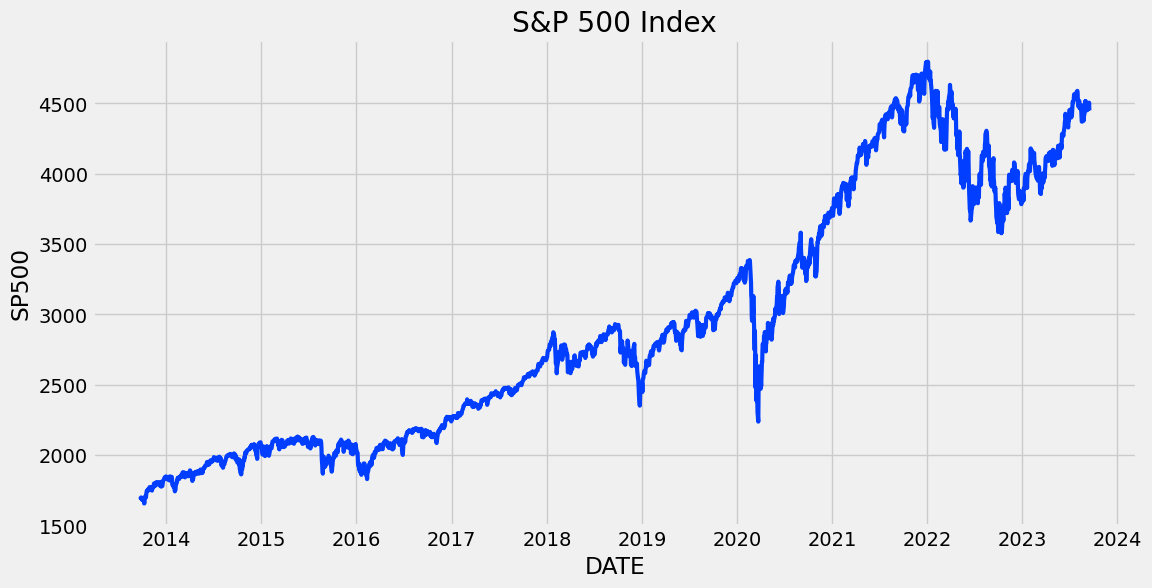

In [195]:
# Plotting the data
plt.figure(figsize=(12, 6)) # size of the plot
sns.lineplot(x='DATE', y='SP500', data=sp500_df, color=colors[0], linewidth=3)
plt.title('S&P 500 Index')
plt.show()

#### **Interactive Plot of the Data**

In [196]:
fig = px.line(sp500_df, x="DATE", y="SP500", title='S&P 500 Index')
fig.show()

#### **Feature Engineering**
Adding the following technical indicators to help with the accuracy of the model:  
  
`prev_close`: Represents yesterday's closing price, and captures the day to day movement of the index. 

`5day_ma`: Keeps track of the 5-day moving average, smoothing out noise, and assists in capturing short term trends.  

`20_day_roc`: The 20 day rate of change, or the % change in value from 20 days prior. Acts as a proxy for the monthly return and momentum.

In [197]:
# Adding a feature for yesterday's prices
sp500_df['prev_close'] = sp500_df['SP500'].shift(1)
sp500_df.head(n=10)

,DATE,SP500,prev_close
0,2013-09-23,1701.84,NaN
1,2013-09-24,1697.42,1701.84
2,2013-09-25,1692.77,1697.42
3,2013-09-26,1698.67,1692.77
4,2013-09-27,1691.75,1698.67
5,2013-09-30,1681.55,1691.75
6,2013-10-01,1695.00,1681.55
7,2013-10-02,1693.87,1695.00
8,2013-10-03,1678.66,1693.87
9,2013-10-04,1690.50,1678.66


In [198]:
# Computing the 5-Day Moving Average 
sp500_df['5day_ma'] = sp500_df['SP500'].rolling(window=5).mean()
sp500_df.head()

,DATE,SP500,prev_close,5day_ma
0,2013-09-23,1701.84,NaN,NaN
1,2013-09-24,1697.42,1701.84,NaN
2,2013-09-25,1692.77,1697.42,NaN
3,2013-09-26,1698.67,1692.77,NaN
4,2013-09-27,1691.75,1698.67,1696.49


In [199]:
# Computing the 20-Day Rate of Change (% change in price compared to 20 days ago)
sp500_df['20_day_roc'] = sp500_df['SP500'].diff(20) / sp500_df['SP500'].shift(20) * 100
sp500_df.head(n=21)

,DATE,SP500,prev_close,5day_ma,20_day_roc
0,2013-09-23,1701.84,NaN,NaN,NaN
1,2013-09-24,1697.42,1701.84,NaN,NaN
2,2013-09-25,1692.77,1697.42,NaN,NaN
3,2013-09-26,1698.67,1692.77,NaN,NaN
4,2013-09-27,1691.75,1698.67,1696.490,NaN
5,2013-09-30,1681.55,1691.75,1692.432,NaN
6,2013-10-01,1695.00,1681.55,1691.948,NaN
7,2013-10-02,1693.87,1695.00,1692.168,NaN
8,2013-10-03,1678.66,1693.87,1688.166,NaN
9,2013-10-04,1690.50,1678.66,1687.916,NaN


In [200]:
sp500_df.tail()

,DATE,SP500,prev_close,5day_ma,20_day_roc
2600,2023-09-11,4487.46,4457.49,4471.680,0.524412
2601,2023-09-12,4461.90,4487.46,4464.694,-0.619638
2602,2023-09-13,4467.44,4461.90,4465.086,0.666537
2603,2023-09-14,4505.10,4467.44,4475.878,2.287976
2604,2023-09-15,4450.32,4505.10,4474.444,1.829598


In [201]:
sp500_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2513 entries, 0 to 2604
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DATE        2513 non-null   datetime64[ns]
 1   SP500       2513 non-null   float64       
 2   prev_close  2512 non-null   float64       
 3   5day_ma     2509 non-null   float64       
 4   20_day_roc  2493 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 117.8 KB


In [202]:
sp500_df.dropna(inplace=True)

In [203]:
# Also adding a new column of elapsed days to convert dates column into a numerical format
# scikit-learn requires numerical inputs - elapsed days maintain temporal information
sp500_df['elapsed_days'] = (sp500_df['DATE'] - sp500_df['DATE'].min()).dt.days
sp500_df.head()

,DATE,SP500,prev_close,5day_ma,20_day_roc,elapsed_days
20,2013-10-21,1744.66,1744.50,1728.382,2.516100,0
21,2013-10-22,1754.67,1744.66,1739.704,3.372766,1
22,2013-10-23,1746.38,1754.67,1744.672,3.166998,2
23,2013-10-24,1752.07,1746.38,1748.456,3.143636,3
24,2013-10-25,1759.77,1752.07,1751.510,4.020689,4


### **Training and Predicting with the Model**

In [204]:
# Splitting into training and test data based on date
train_df = sp500_df[sp500_df['DATE'] < '2018-10-15']
test_df = sp500_df[sp500_df['DATE'] >= '2018-10-15']

X_train = train_df[['elapsed_days', 'prev_close', '5day_ma', '20_day_roc']]
y_train = train_df['SP500']

X_test = test_df[['elapsed_days', 'prev_close', '5day_ma', '20_day_roc']] 
y_test = test_df['SP500']

In [205]:
# Creating the model
model = LinearRegression()

In [206]:
# Training the model
model.fit(X_train, y_train)

LinearRegression()

In [207]:
# Predicting on the test data
preds = model.predict(X_test)

### **Evaluating the Model**

In [208]:
#Plotting the forecast vs actual values (Interactive)
results_df = pd.DataFrame()
results_df['Date'] = test_df['DATE']
results_df['Actuals'] = y_test
results_df['Forecast'] = preds

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=results_df['Date'], y=results_df['Actuals'], mode='lines', name='Actuals',line=dict(color='blue')))
fig2.add_trace(go.Scatter(x=results_df['Date'], y=results_df['Forecast'], mode='lines', name='Forecast',line=dict(color='red')))
fig2.update_layout(title_text='Forecast vs. Actuals')
fig2.show()

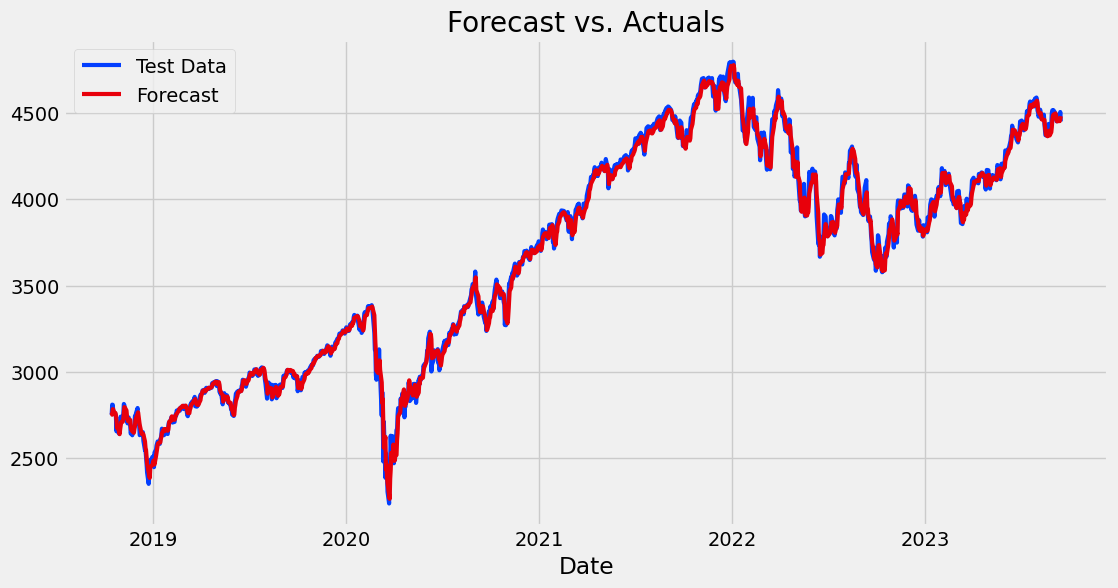

In [212]:
#Static plot of the forecast vs actual values 
plt.figure(figsize=(12, 6)) # size of the plot
sns.lineplot(x='Date', y='Actuals', data=results_df, label='Test Data', color=colors[0], linewidth=3)
sns.lineplot(x='Date', y='Forecast', data=results_df, label='Forecast', color=colors[3], linewidth=3)
plt.ylabel('')
plt.title('Forecast vs. Actuals')
plt.show()

In [210]:
# Error Metrics
y_true = y_test
y_pred = preds

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true=y_true, y_pred=y_pred)
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))
# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# Coefficient of Determination R^2
rsquare = r2_score(y_true=y_true, y_pred=y_pred)

print(f'MAE: {mae}\nRMSE: {rmse}\nMAPE: {mape}\nR^2: {rsquare}')

MAE: 30.64997307431314
RMSE: 42.2434513459018
MAPE: 0.8528535127999657
R^2: 0.9957657709572295
